In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## set up pyspark session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/08 09:15:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## set up config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Build Bronze Table

In [5]:
# create bronze datalake
bronze_lms_directory = "datamart/bronze/lms/"

if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)

In [6]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_lms_directory, spark)


2023-01-01row count: 530
saved to: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv
2023-04-01row count: 2047
saved to: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv
2023-05-01row count: 2568
saved to: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv
2023-06-01row count: 3085
saved to: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv
2023-07-01row count: 3556
saved to: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv
2023-08-01row count: 4037
saved to: datamart/bronze/lms/bronze_loan_daily_2023_08_01.csv
2023-09-01row count: 4491
saved to: datamart/bronze/lms/bronze_loan_daily_2023_09_01.csv
2023-10-01row count: 4978
saved to: datamart/bronze/lms/bronze_loan_daily_2023_10_01.csv
2023-11-01row count: 5469
saved to: datamart/bronze/lms/bronze_loan_daily_2023_11_01.csv
2023-12-01row count: 5

In [7]:
# inspect output
utils.data_processing_bronze_table.process_bronze_table(date_str, bronze_lms_directory, spark).toPandas()

2024-12-01row count: 5531
saved to: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000,1000.0,1000.0,0.0,1000.0,2024-12-01
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000,1000.0,0.0,6000.0,8000.0,2024-12-01
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000,1000.0,0.0,9000.0,9000.0,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...
5526,CUS_0xfe3_2024_04_01,CUS_0xfe3,2024-04-01,10,8,10000,1000.0,1000.0,0.0,2000.0,2024-12-01
5527,CUS_0xff3_2024_06_01,CUS_0xff3,2024-06-01,10,6,10000,1000.0,1000.0,0.0,4000.0,2024-12-01
5528,CUS_0xff4_2024_12_01,CUS_0xff4,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
5529,CUS_0xff6_2024_10_01,CUS_0xff6,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01


## Build Silver Table

In [8]:
# create bronze datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)

In [9]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark)


loaded from: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv row count: 530
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv row count: 1031
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv row count: 1537
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv row count: 2047
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv row count: 2568
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv row count: 3085
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv

In [10]:
utils.data_processing_silver_table.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark).toPandas()

loaded from: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv row count: 5531
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000.0,1000.0,1000.0,0.0,1000.0,2024-12-01,9,0,None,0
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000.0,1000.0,0.0,6000.0,8000.0,2024-12-01,8,6,2024-06-01,183
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000.0,1000.0,1000.0,0.0,8000.0,2024-12-01,2,0,None,0
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2024-12-01,0,0,None,0
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000.0,1000.0,0.0,9000.0,9000.0,2024-12-01,10,9,2024-03-01,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,CUS_0xfe3_2024_04_01,CUS_0xfe3,2024-04-01,10,8,10000.0,1000.0,1000.0,0.0,2000.0,2024-12-01,8,0,None,0
5527,CUS_0xff3_2024_06_01,CUS_0xff3,2024-06-01,10,6,10000.0,1000.0,1000.0,0.0,4000.0,2024-12-01,6,0,None,0
5528,CUS_0xff4_2024_12_01,CUS_0xff4,2024-12-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2024-12-01,0,0,None,0
5529,CUS_0xff6_2024_10_01,CUS_0xff6,2024-10-01,10,2,10000.0,1000.0,1000.0,0.0,8000.0,2024-12-01,2,0,None,0


## EDA on credit labels

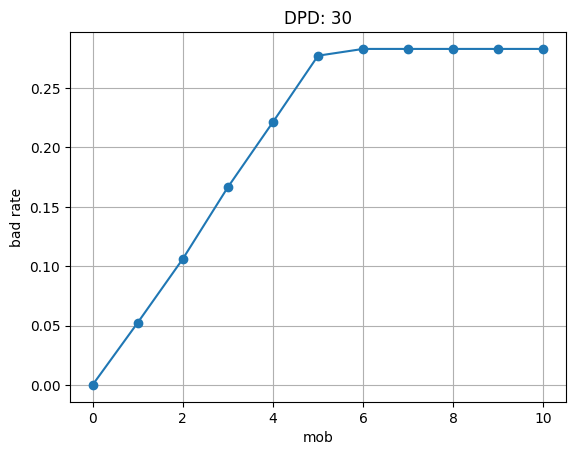

In [11]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [12]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|Customer_ID|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

## Build gold table for labels

In [13]:
# create bronze datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [14]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet row count: 1031
saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet row count: 1537
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet row count: 2047
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from

In [15]:
utils.data_processing_gold_table.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes


loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

## inspect label store

In [16]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [17]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)

